 <font size="3">Test `TimeseriesExtractor` using the test dataset if not using a Windows machine since pybids is needed.</font>

In [1]:
import os, sys, warnings
warnings.simplefilter('ignore')
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts
import numpy as np, joblib
from matplotlib.colors import LinearSegmentedColormap
from seaborn import diverging_palette

parcel_approach = {"Schaefer": {"n_rois": 100}}
#parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = parcel_approach["Schaefer"]["n_rois"] if "Schaefer" in parcel_approach.keys() else 116

if sys.platform != "win32":
    if os.path.basename(os.path.dirname(__vsc_ipynb_file__)) == "neurocaps":
        bids_dir = "tests/ds000031_R1.0.4_ses001-022/ds000031_R1.0.4/"
        pipeline_name = "fmriprep_1.0.0/fmriprep"
        confounds=["Cosine*", "aComp*", "Rot*"]

        extractor = TimeseriesExtractor(parcel_approach=parcel_approach, standardize="zscore_sample",
                                        use_confounds=True, detrend=False, low_pass=0.15, high_pass=None,
                                        confound_names=confounds)

        extractor.get_bold(bids_dir=bids_dir, session='002', runs="001",task="rest", pipeline_name=pipeline_name,tr=1.2)

 <font size="3">Create random data. The `subject_timeseries` property is also a setter.</font>

In [2]:
extractor = TimeseriesExtractor(parcel_approach=parcel_approach)
extractor.subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,ncol) for y in range(1,4)} for x in range(1,11)}


List of confound regressors that will be used during timeseries extraction if available in confound
dataframe - ['cosine*', 'trans_x', 'trans_x_derivative1', 'trans_y', 'trans_y_derivative1', 'trans_z', 'trans_z_derivative1', 'rot_x', 'rot_x_derivative1', 'rot_y', 'rot_y_derivative1', 'rot_z', 'rot_z_derivative1', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']


 <font size="3">Creating a pickle file of the `subject_timeseries`. </font>

In [3]:
output_dir = os.path.dirname(__vsc_ipynb_file__)

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_for_neurocaps_demo_timeseries.pkl")

with open("sample_for_neurocaps_demo_timeseries.pkl", "rb") as f:
    subject_timeseries = joblib.load(f)


 <font size="3">Visualizing bold with the `visualize_bold` method from `TimeseriesExtractor`.</font>

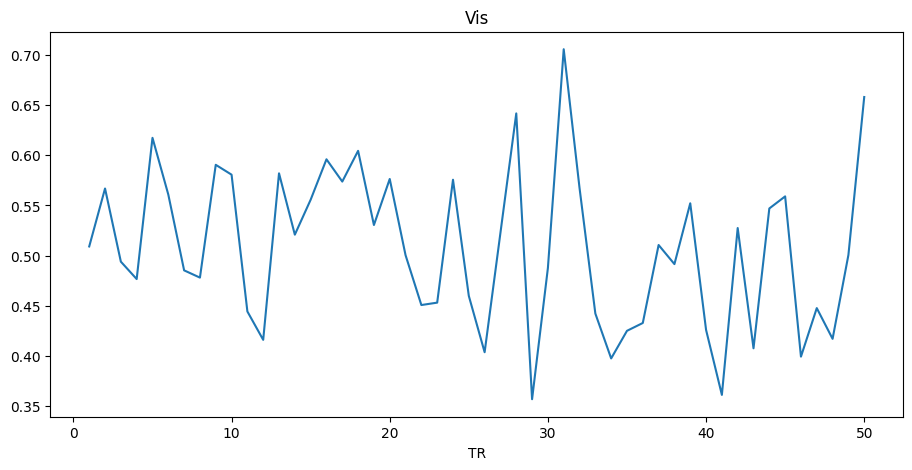

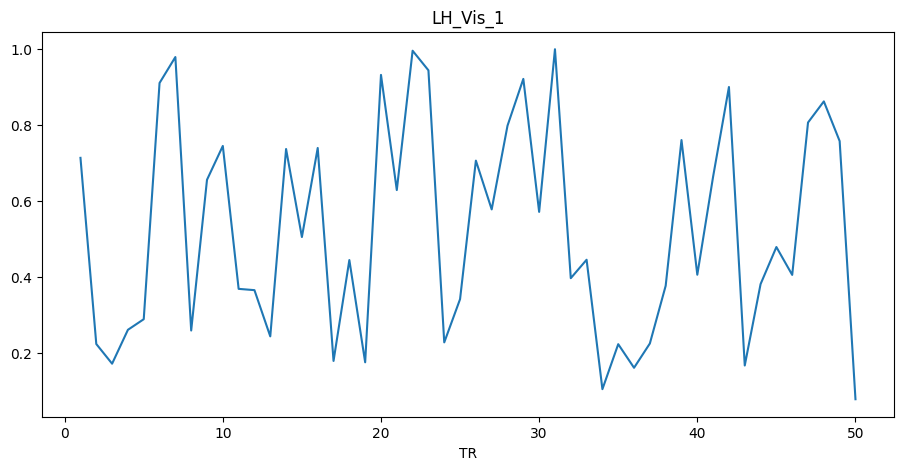

In [4]:
if ncol == 116:
    extractor.visualize_bold(subj_id="1",run=1, region="Cerebelum")
    extractor.visualize_bold(subj_id="1",run=1, roi_indx=0)
else:
    extractor.visualize_bold(subj_id="1",run=1, region="Vis")
    extractor.visualize_bold(subj_id="1",run=1, roi_indx=0)

 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method.</font>

[GROUP: High ADHD | METHOD: elbow] - Optimal cluster size is 10.


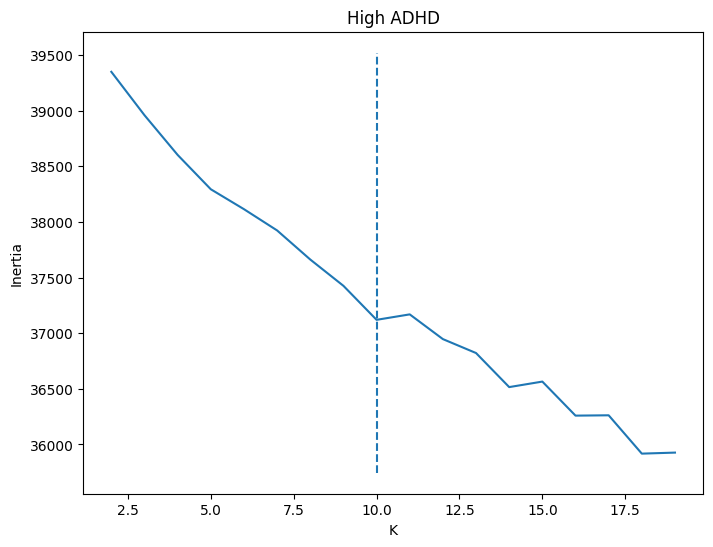

[GROUP: Low ADHD | METHOD: elbow] - Optimal cluster size is 10.


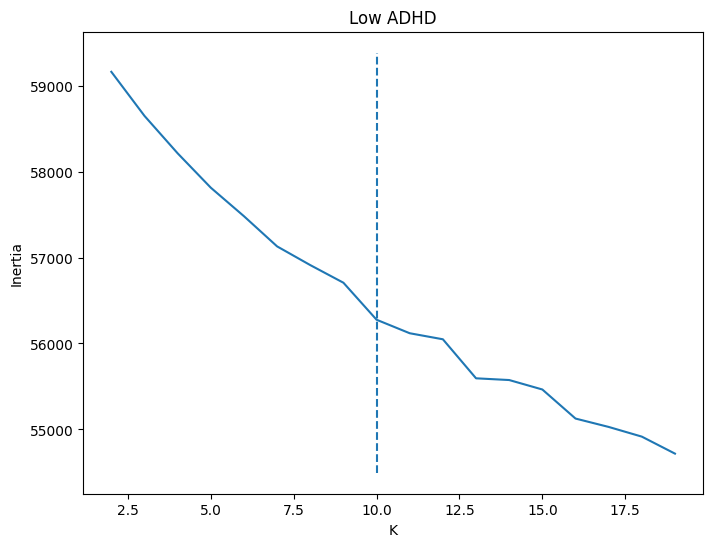

In [5]:
cap_analysis = CAP(groups={"High ADHD": ["1","2","3","5"], "Low ADHD": ["4","6","7","8","9","10"]})
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries, runs=[1,2],
                      n_clusters=list(range(2,20)), cluster_selection_method="elbow", show_figs=True)

 <font size="3">Getting CAP metrics using the `calculate_metrics` method.</font>

In [6]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)

{'temporal_fraction':    Subject_ID      Group    Run  CAP-1  CAP-2  CAP-3  CAP-4  CAP-5  CAP-6  \
 0           1  High_ADHD  run-1   0.04   0.10   0.08   0.18   0.12   0.12   
 1           1  High_ADHD  run-2   0.08   0.18   0.16   0.04   0.06   0.08   
 2           1  High_ADHD  run-3   0.16   0.12   0.08   0.16   0.10   0.10   
 3           2  High_ADHD  run-1   0.12   0.10   0.14   0.10   0.14   0.02   
 4           2  High_ADHD  run-2   0.06   0.14   0.04   0.20   0.14   0.06   
 5           2  High_ADHD  run-3   0.06   0.16   0.02   0.18   0.08   0.08   
 6           3  High_ADHD  run-1   0.08   0.18   0.02   0.26   0.10   0.08   
 7           3  High_ADHD  run-2   0.14   0.08   0.12   0.16   0.16   0.06   
 8           3  High_ADHD  run-3   0.08   0.10   0.20   0.12   0.14   0.08   
 9           5  High_ADHD  run-1   0.08   0.12   0.06   0.14   0.20   0.08   
 10          5  High_ADHD  run-2   0.08   0.12   0.14   0.22   0.10   0.06   
 11          5  High_ADHD  run-3   0.10   0

 <font size="3">The `subject_table` property in the `CAP` class also acts has a setter and can be used to add an additional subject.</font>

In [7]:
subject_table = cap_analysis.subject_table
subject_table.update({"11": "High ADHD"})
cap_analysis.subject_table = subject_table
cap_analysis.subject_table

{'1': 'High ADHD',
 '2': 'High ADHD',
 '3': 'High ADHD',
 '5': 'High ADHD',
 '4': 'Low ADHD',
 '6': 'Low ADHD',
 '7': 'Low ADHD',
 '8': 'Low ADHD',
 '9': 'Low ADHD',
 '10': 'Low ADHD',
 '11': 'High ADHD'}

In [8]:
subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,ncol) for y in range(1,4)} for x in range(1,12)}
cap_analysis.calculate_metrics(subject_timeseries=subject_timeseries, metrics="counts")

{'counts':    Subject_ID      Group    Run  CAP-1  CAP-2  CAP-3  CAP-4  CAP-5  CAP-6  \
 0           1  High_ADHD  run-1      4      7      5      9      4      5   
 1           1  High_ADHD  run-2      4      1      7     13      9      4   
 2           1  High_ADHD  run-3     10      6      4      7      4      2   
 3           2  High_ADHD  run-1      7      7      2     10      7      3   
 4           2  High_ADHD  run-2      2      6      5     11      9      6   
 5           2  High_ADHD  run-3      5      7      9      6      5      2   
 6           3  High_ADHD  run-1      4      7      6      7      5      3   
 7           3  High_ADHD  run-2      5     10      3     10      4      3   
 8           3  High_ADHD  run-3      5      7      1     16      3      5   
 9           5  High_ADHD  run-1      6      6      4      8      7      3   
 10          5  High_ADHD  run-2      6      8      4     10      6      3   
 11          5  High_ADHD  run-3      6      6      4 

 <font size="3">Using the the pickled subject timeseries as an input instead. All `subject_timeseries` parameters in the `neurocaps` class accepts pickles.</font>

[GROUP: High ADHD | METHOD: silhouette] - Optimal cluster size is 2.


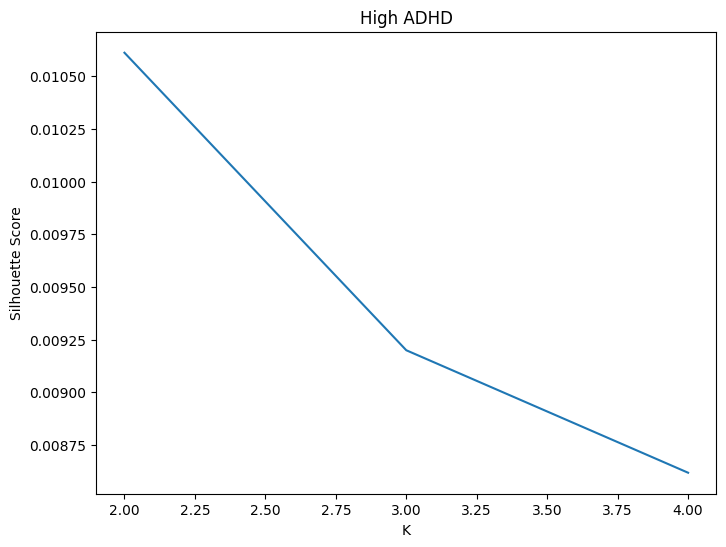

[GROUP: Low ADHD | METHOD: silhouette] - Optimal cluster size is 2.


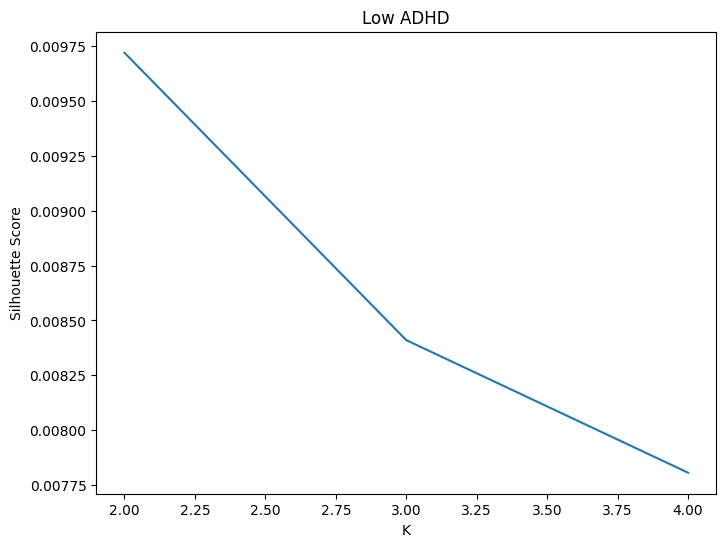

{'High ADHD': KMeans(n_clusters=2), 'Low ADHD': KMeans(n_clusters=2)}

In [9]:
cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl",
                      n_clusters=list(range(2,5)),
                      cluster_selection_method="silhouette", show_figs=True)
cap_analysis.kmeans

In [10]:
cap_analysis.calculate_metrics(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl", metrics="counts")

{'counts':    Subject_ID      Group    Run  CAP-1  CAP-2
 0           1  High_ADHD  run-1     20     30
 1           1  High_ADHD  run-2     23     27
 2           1  High_ADHD  run-3     22     28
 3           2  High_ADHD  run-1     20     30
 4           2  High_ADHD  run-2     26     24
 5           2  High_ADHD  run-3     26     24
 6           3  High_ADHD  run-1     26     24
 7           3  High_ADHD  run-2     31     19
 8           3  High_ADHD  run-3     23     27
 9           5  High_ADHD  run-1     26     24
 10          5  High_ADHD  run-2     29     21
 11          5  High_ADHD  run-3     20     30
 12          4   Low_ADHD  run-1     27     23
 13          4   Low_ADHD  run-2     24     26
 14          4   Low_ADHD  run-3     26     24
 15          6   Low_ADHD  run-1     28     22
 16          6   Low_ADHD  run-2     27     23
 17          6   Low_ADHD  run-3     26     24
 18          7   Low_ADHD  run-1     31     19
 19          7   Low_ADHD  run-2     27     23
 20

 <font size="3">`parcel_approach` can be during initialization of the `CAP` class or later when needed for visualization purposes. When setting the `parcel_approach` using the `self.parcel_approach` property pickles can be used to. This makes it easier if you are using a parcellation outside of Schaefer or AAL or you are using a modified version of these parcellations.</font>

In [11]:
cap_analysis.parcel_approach = parcel_approach

 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `caps2plot` method.</font>

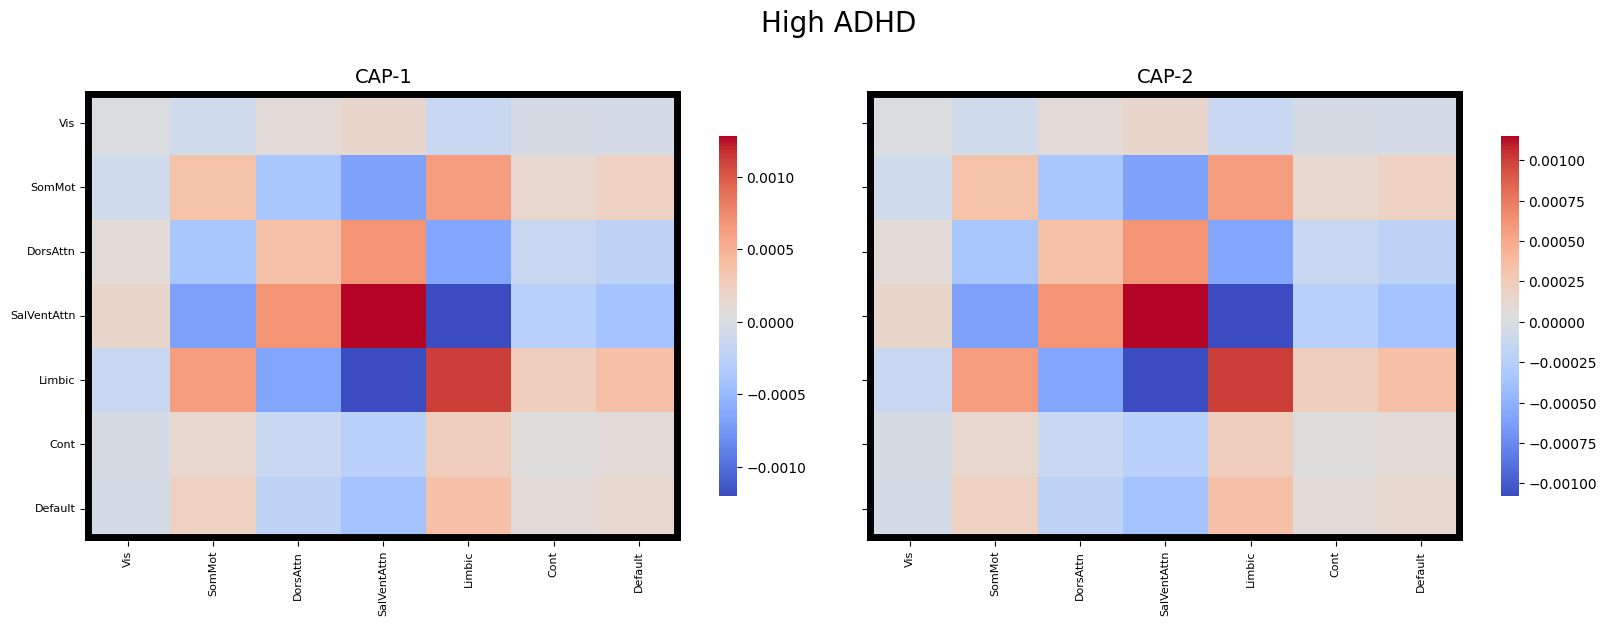

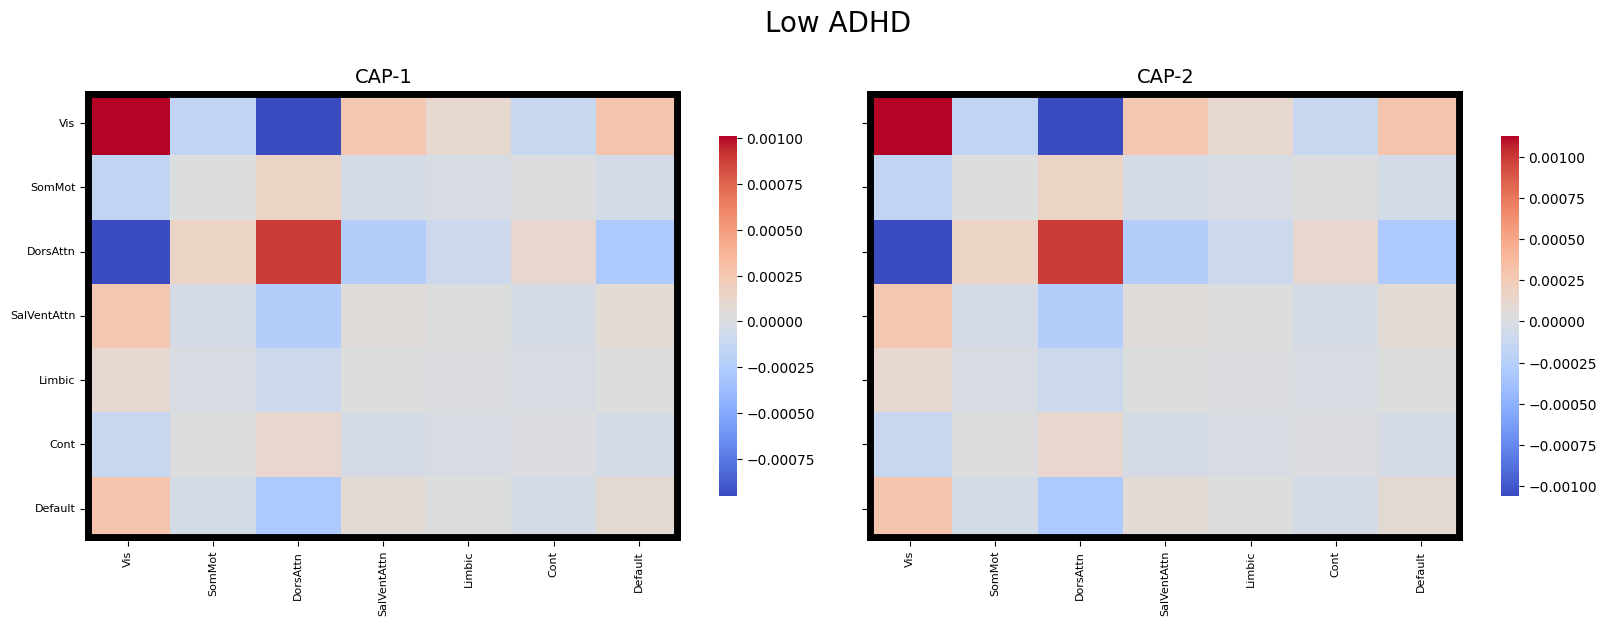

In [12]:
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10)

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `caps2plot` method.</font>

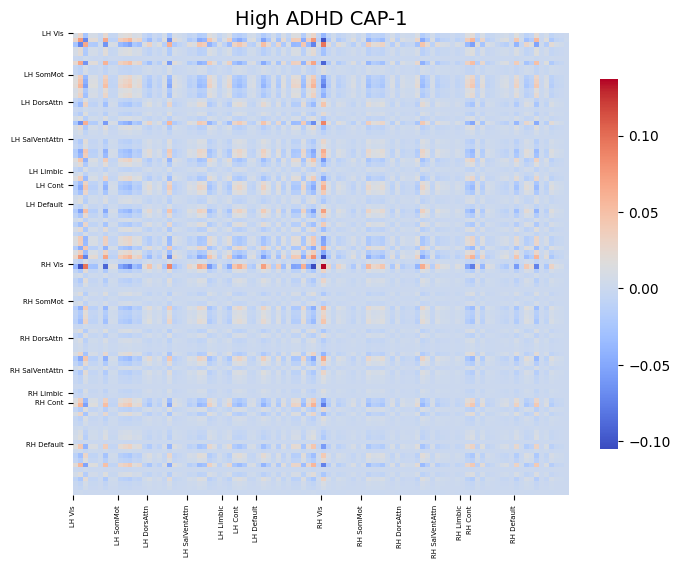

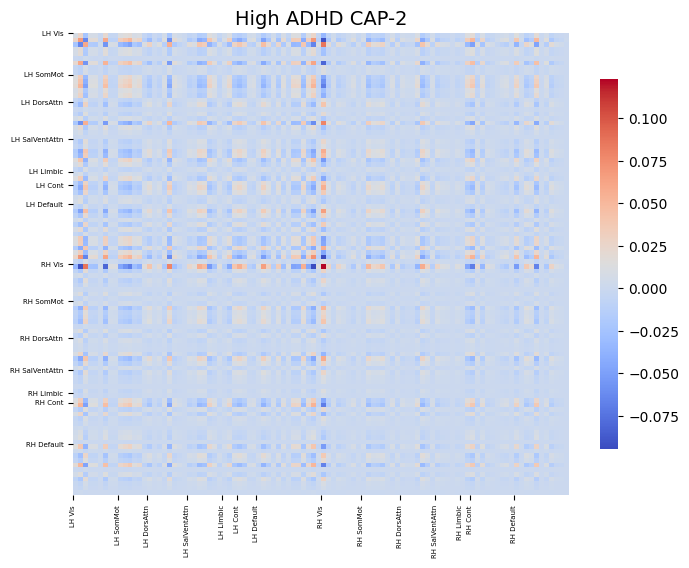

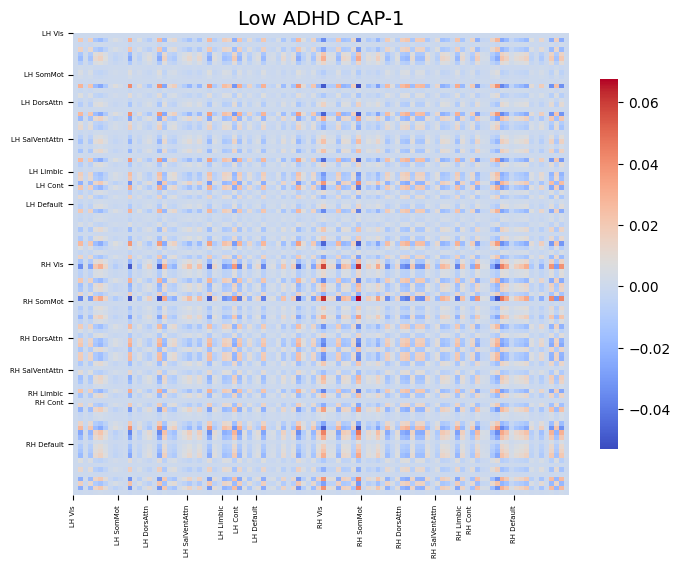

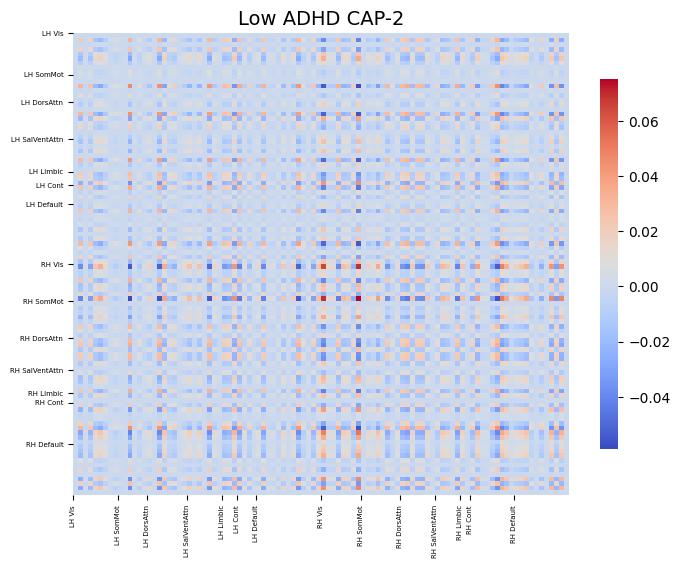

In [13]:
cap_analysis.caps2plot(subplots=False, yticklabels_size=5, wspace = 0.1, visual_scope="nodes", xlabel_rotation=90,
                       xticklabels_size = 5, hspace = 0.6, tight_layout = False)

 <font size="3">Visualizing CAPs as heatmaps at the regional level and using the `hemishere_labels` parameter to label the left and right hemispheres using `caps2plot` method.</font>

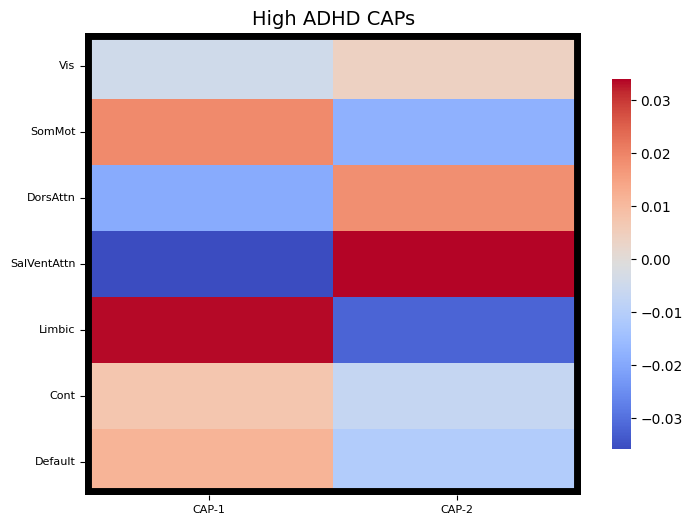

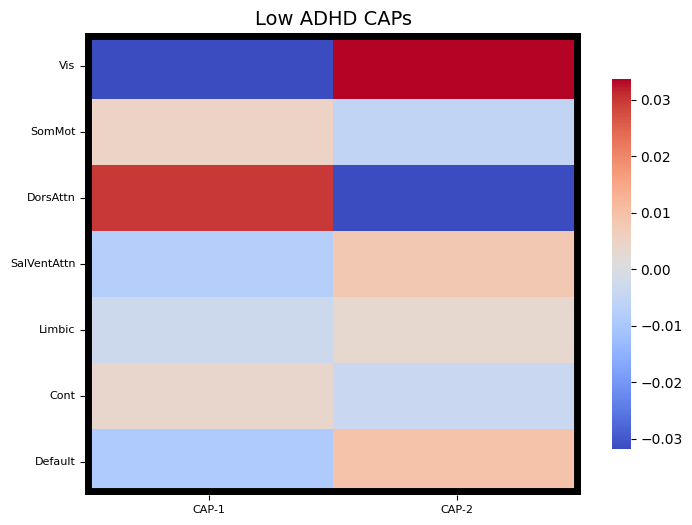

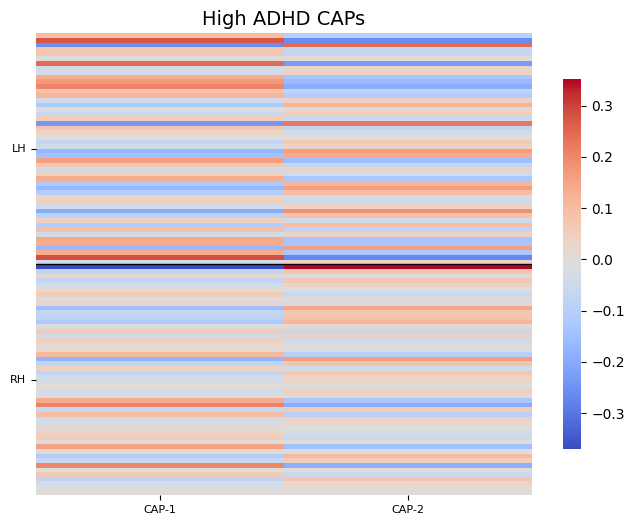

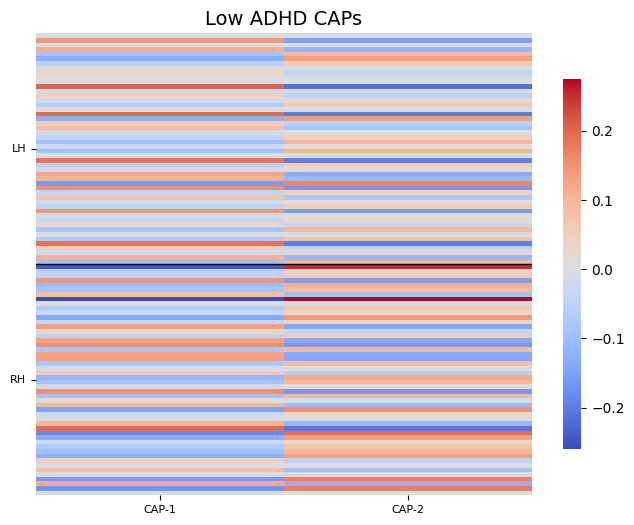

In [14]:
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10)
cap_analysis.caps2plot(subplots=True, visual_scope="nodes", plot_options="heatmap", hemisphere_labels = True)

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the combined dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When combined, only subjects that have at least a single run across sessions will be returned in the combined dictionary. When `return_reduced_dicts` is True, only the subjects in the combined dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "combined" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [15]:
# Individual plots. In the event you wnat to merge TRs from two dictionaries conatining the same subject to find common CAPs across a task
subject_timeseries_1 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,11)}
subject_timeseries_2 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,7)}

# Returns combined dictionary as well as the reduced subject dictionaries containing only the subjects present in the combined
all_dicts = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                        return_combined_dict=True, return_reduced_dicts=True)
# Only the combined subject dictionary
subject_timeseries_combined = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                                          return_combined_dict=True, return_reduced_dicts=False)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["combined"].keys())

dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])


In [16]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)
cap_analysis.get_caps(subject_timeseries=subject_timeseries_combined, n_clusters=3)

In [17]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_0"],return_df=True, runs=[1,2])
output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All_Subjects,run-1,0.28,0.34,0.38
1,1,All_Subjects,run-2,0.33,0.31,0.36
2,2,All_Subjects,run-1,0.31,0.30,0.39
3,2,All_Subjects,run-2,0.39,0.28,0.33
4,3,All_Subjects,run-1,0.33,0.34,0.33
5,3,All_Subjects,run-2,0.39,0.34,0.27
6,4,All_Subjects,run-1,0.29,0.34,0.37
7,4,All_Subjects,run-2,0.31,0.27,0.42
8,5,All_Subjects,run-1,0.32,0.40,0.28
9,5,All_Subjects,run-2,0.32,0.31,0.37


In [18]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_1"],return_df=True, runs=[1,2])
output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All_Subjects,run-1,0.31,0.32,0.37
1,1,All_Subjects,run-2,0.37,0.37,0.26
2,2,All_Subjects,run-1,0.38,0.31,0.31
3,2,All_Subjects,run-2,0.32,0.29,0.39
4,3,All_Subjects,run-1,0.26,0.43,0.31
5,3,All_Subjects,run-2,0.30,0.38,0.32
6,4,All_Subjects,run-1,0.32,0.38,0.30
7,4,All_Subjects,run-2,0.32,0.31,0.37
8,5,All_Subjects,run-1,0.36,0.31,0.33
9,5,All_Subjects,run-2,0.41,0.33,0.26


 <font size="3">Visualizing CAPs as outer product heatmap at the network level using `caps2plot` method with the `subplots` parameter set to True.</font>

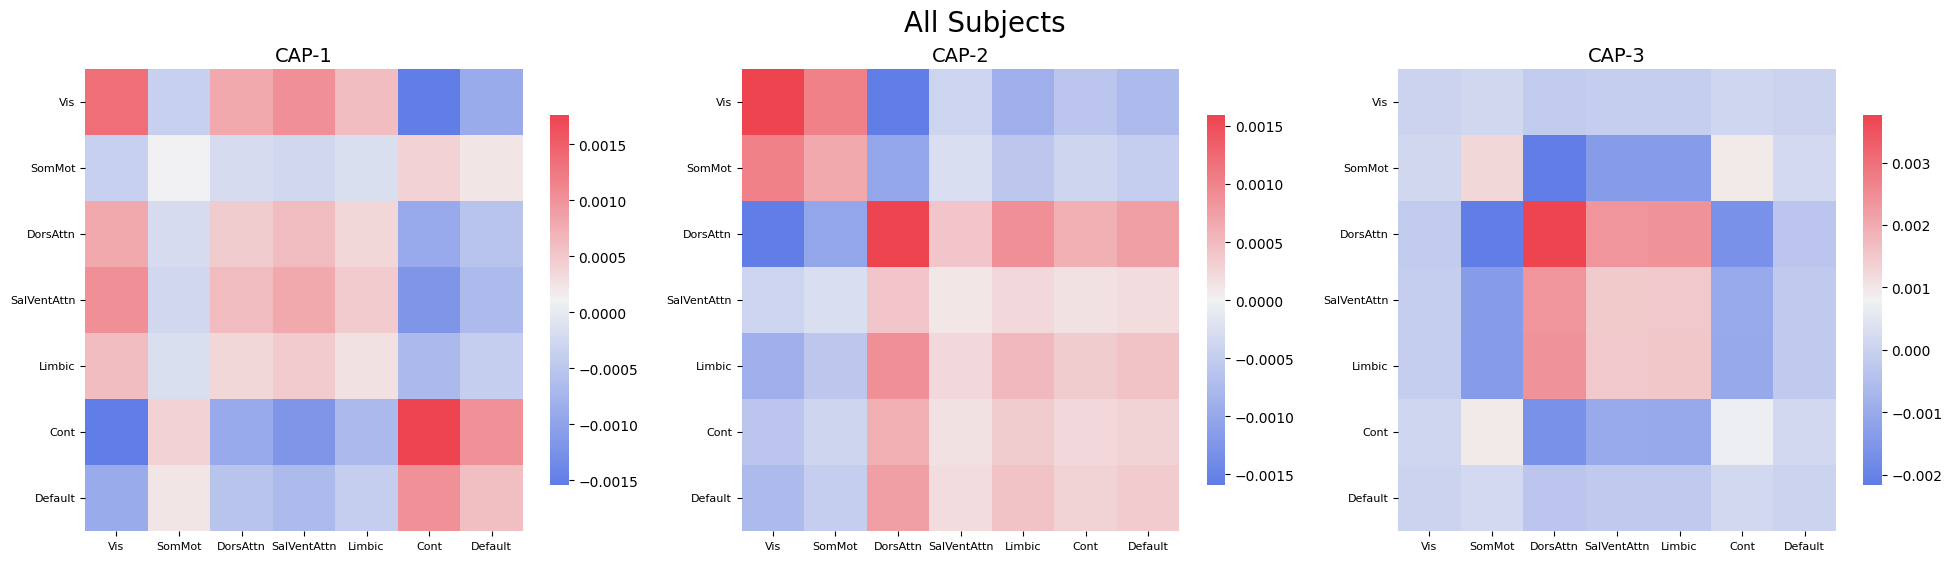

In [19]:
import seaborn as sns
sns.diverging_palette(145, 300, s=60, as_cmap=True)
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer_product", subplots=True, fontsize=14, ncol=6,
                       sharey=False, tight_layout=False, xlabel_rotation=0, hspace = 0.3, cmap=palette)

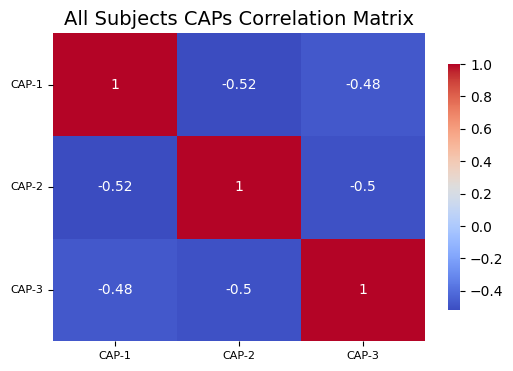

In [20]:
import seaborn as sns
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2corr(annot=True, figsize=(6,4))

 <font size="3">Visualizing CAPs as surface plots using `caps2surf` method.</font>

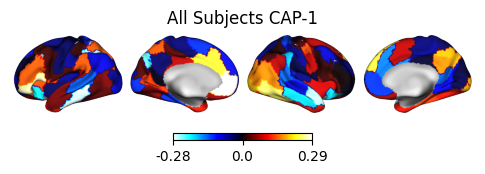

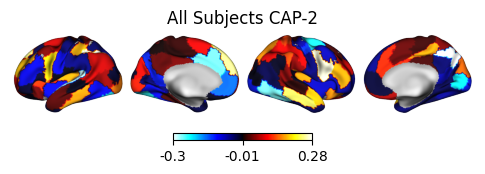

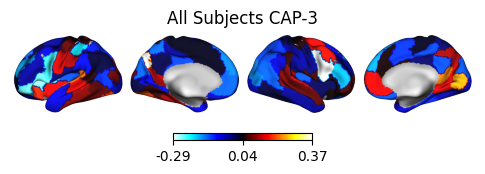

In [21]:
cap_analysis.caps2surf(cmap="cold_hot", layout="row",  size=(500, 100))

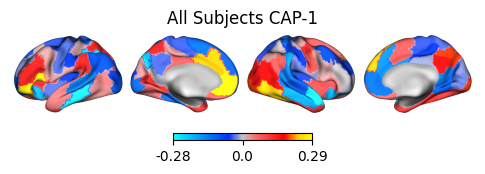

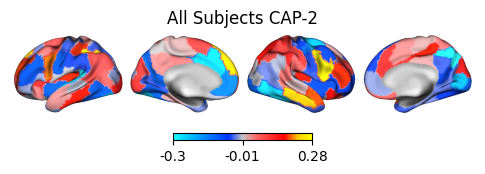

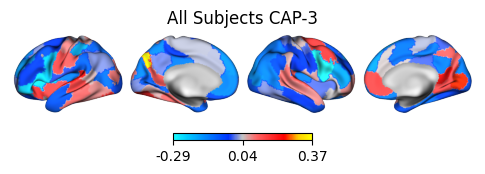

In [22]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#1bfffe", "#00ccff", "#0099ff", "#0066ff", "#0033ff", "#c4c4c4", "#ff6666", 
          "#ff3333", "#FF0000","#ffcc00","#FFFF00"]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)
cap_analysis.caps2surf(cmap=custom_cmap, size=(500, 100), layout="row")

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files.</font>

In [23]:
cap_analysis.caps2niftis(output_dir=output_dir, suffix_file_name="for_neurocaps_demo")

 <font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse, there is a `knn_dict` parameter in both `caps2surf` and `caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference.</font>

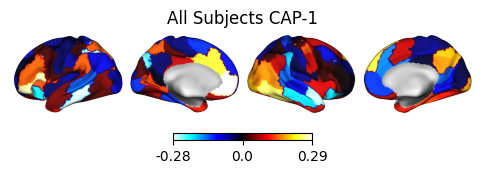

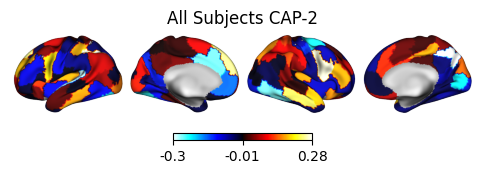

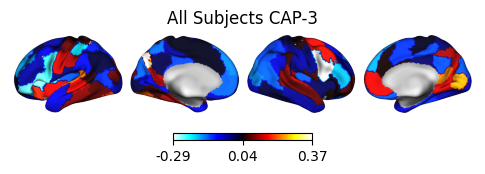

In [24]:
cap_analysis.caps2surf(cmap="cold_hot", layout="row",  size=(500, 100), knn_dict={"k":5, "resolution_mm":2})

 <font size="3">Radar plots showing the cosine of each network/region can be produced for each CAP to show the dominant network/regions for each CAP. There are three ways cosine similarity is calculated that primarily influence the norming in the denominator for cosine similarity - "traditional" (the traditional cosine similarity calculation that uses the full CAP vector), "selective" (filters out only the relevant  nodes in the CAP vector to assess internal consistency within a network for each CAP), "combined" (a weighted approach for both where the weight is determined by the `alpha` parameter). The default is "traditional" and the cosine similarities are stored in the `self.cosine_similarity` property.</font>

In [25]:
radialaxis={"showline": True, "linewidth": 2, "linecolor": "rgba(0, 0, 0, 0.25)", "gridcolor": "rgba(0, 0, 0, 0.25)",
            "ticks": "outside" , "tickfont": {"size": 14, "color": "black"}, "range": [0,0.3],
            "tickvals": [0.1,0.2,0.3]}
cap_analysis.caps2radar(method="traditional", radialaxis=radialaxis, fill="toself")

In [26]:
cap_analysis.cosine_similarity

{'All Subjects': {'regions': ['Vis',
   'SomMot',
   'DorsAttn',
   'SalVentAttn',
   'Limbic',
   'Cont',
   'Default'],
  'CAP-1': [0.12492035286331525,
   -0.0298277719370312,
   0.06903205622342733,
   0.08088009942731884,
   0.030634100864507702,
   -0.12467096845603151,
   -0.0978499377682781],
  'CAP-2': [-0.13366593608251162,
   -0.07845939395280874,
   0.12551090266238585,
   0.02884108902633768,
   0.04111661760649574,
   0.04439355844253365,
   0.07506641806627841],
  'CAP-3': [0.010778862125445368,
   0.11095551608777522,
   -0.1991162783949553,
   -0.11170168238581066,
   -0.07336357198662004,
   0.08079141717857374,
   0.022037609164779173]}}

 <font size="3">Removes the files generated in this demo.</font>

In [27]:
os.remove("sample_for_neurocaps_demo_timeseries.pkl")
[os.remove(x) for x in ["All_Subjects_CAP_1_for_neurocaps_demo.nii.gz", "All_Subjects_CAP_2_for_neurocaps_demo.nii.gz", "All_Subjects_CAP_3_for_neurocaps_demo.nii.gz"]]

[None, None, None]